# Reproducing figures in Meeker and Mayewski (2002) using GISP2 data

See the README file in the directory with this example for more detailed information on the objectives of this example, including information on the source data.

In [2]:
#load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import BSpline

In [3]:
#load the dataset (assumes data is located in a subdirectory of this jupyter notebook called 'data')
ion = pd.read_csv('./data/iond.txt',sep='\t', skiprows=37, header=None,\
                  names=['depth_top','depth_bot','Na','NH4','K','Mg','Ca','Cl','NO3','SO4','age_top','age_bot'])

## challenges so far:

- need to manually enter in column names (because original data has them in >1 row); not same for all files
- irregular number of rows to skip for each file
- currently units are not added/stored in the dataframe and would need to be added manually similar to column names
- need to know and manually enter the no data value (below), which is not stated on all data descriptions
- need to interpolate (smooth) the data... and this must be done using a matlab script from Meeker...

In [4]:
#turn no data values into nans and compute date column
ion = ion.mask(np.isclose(ion,999999), np.nan)
ion['age_cent_calyr'] = 1950 - (ion.age_top - (ion.age_top-ion.age_bot)/2.0)


In [5]:
ion.columns

Index(['depth_top', 'depth_bot', 'Na', 'NH4', 'K', 'Mg', 'Ca', 'Cl', 'NO3',
       'SO4', 'age_top', 'age_bot', 'age_cent_calyr'],
      dtype='object')

In [6]:
min(ion.age_cent_calyr)
max(ion.age_cent_calyr)

1985.3

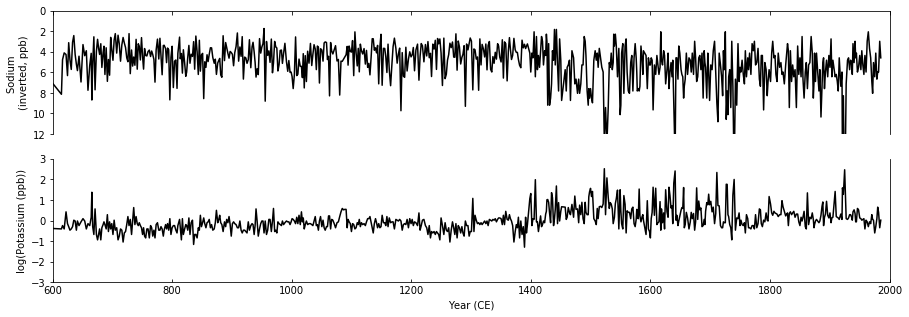

In [7]:
#make some data plots!
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(15,5), squeeze=False)

#plot data
axes[0,0].plot(ion.age_cent_calyr, ion.Na, color='k')
axes[1,0].plot(ion.age_cent_calyr, np.log(ion.K), color='k')

#data shading

#set figure limits
xmin=600  #min(ion.age_cent_calyr)-2000
xmax=2000  #max(ion.age_cent_calyr)+2000
axes[0,0].set_xlim(xmin,xmax)
axes[1,0].set_xlim(xmin,xmax)
#axes[2,0].set_xlim(xmin,xmax)

Na_ymin=12 #10
Na_ymax=0 #2
axes[0,0].set_ylim(Na_ymin,Na_ymax)

K_ymin=-3
K_ymax=3
axes[1,0].set_ylim(K_ymin,K_ymax)

#remove unneeded axes lines
row_counter = 0
while row_counter < rows:
    #kwargs = dict(transform=axes[row_counter, 0].transAxes, color='k', clip_on=False)
    
    if row_counter < rows-1: #all rows but bottom-most graphs    
        #axes[row_counter, 0].get_xaxis().set_visible(False)
        axes[row_counter,0].tick_params(axis='x', labelbottom=False, bottom=False)
        axes[row_counter,0].spines['bottom'].set_visible(False)
        
    if row_counter==0: #only the top-most graph
        axes[row_counter,0].tick_params(axis='x', top=True, direction='in')
    
    row_counter = row_counter + 1
    
    
#modify the lines of the bottom-most plot
axes[rows-1,0].spines['top'].set_visible(False)    
axes[rows-1,0].tick_params(axis='x', labeltop=False, top=False, direction='in')

#add gridlines


#axes[0,0].legend(loc=2)

axes[0,0].set_ylabel('Sodium \n(inverted, ppb)')
axes[1,0].set_ylabel('log(Potassium (ppb))')
axes[rows-1,0].set_xlabel('Year (CE)')


plt.show()

In [66]:
#experiment with the engine to call matlab functions from python rather than having to bring the dataset into python
#any matlab toolboxes/functions (e.g. rbsp) you want to use have to be in your matlabpath
import matlab as mlb
import matlab.engine
eng = matlab.engine.start_matlab()

In [53]:
#create copy of dataframe that only has the time period of interest in it to speed up processing
ion2 = ion.copy(deep=True)
ion2 = ion2.loc[ion.age_cent_calyr>600,:]

In [83]:
#use the matlab smoothing function and resample the dates to plot the smoothed data
#NOTE: the matlab function does not handle NAN values!!!!

#convert the python pandas series (or any array) into matlab formatted column vectors
#POTENTIAL CODE IMPROVEMENT: make this into a function to make it easier to use the matlab smoothers
age = mlb.double(np.vstack(ion2.age_cent_calyr).tolist())
na = mlb.double(np.vstack(ion2.Na).tolist())
k = mlb.double(np.vstack(ion2.K).tolist())

In [201]:
#run the smoother and put the returned, smoothed data into the df
#The last non kwarg 1 as input makes figures of the data and smoothed data show up (in a matlab figure window).
#must run the series one at a time to see both output figures
[smooth, res] = eng.rbsp(age,na,0.15,1,nargout=2)
[ion2["Na_spl"],ion2["Na_spl_res"]] = np.hstack(smooth), np.hstack(res)

[smooth,res] = eng.rbsp(age,k,0.15,1,nargout=2)
[ion2["K_spl"],ion2["K_spl_res"]] = np.hstack(smooth), np.hstack(res)

smooth=None; res=None

In [144]:
#run the running mean smoother and put the returned, smoothed data into the df
#Note column added to df has not had name changed to make plotting easier
smooth = eng.rmean(na,10,0,0,nargout=1)
ion2["Na_spl"] = np.hstack(smooth)

smooth = eng.rmean(k,10,0,0,nargout=1)
ion2["K_spl"] = np.hstack(smooth)

smooth=None

In [143]:
ion2.age_cent_calyr[33]-ion2.age_cent_calyr[45]
#15-27 has 19.95 years in between
#33-45 has 24.45 years in between

24.450000000000045

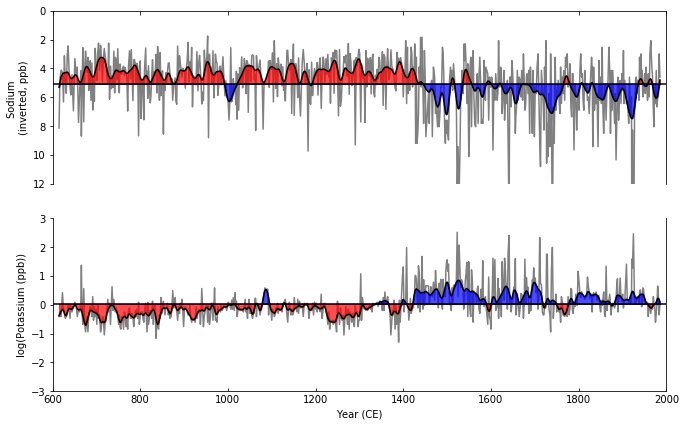

In [205]:
#make some data plots - now with smoothed data! (copied from above cell and modified to add smoothed data)
#note switch from using ion (all data) df to ion2 (limited time series) df
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(11,7), squeeze=False)

#plot data (original)
axes[0,0].plot(ion2.age_cent_calyr, ion2.Na, color='gray')
axes[1,0].plot(ion2.age_cent_calyr, np.log(ion2.K), color='gray')

#plot smoothed data
axes[0,0].plot(ion2.age_cent_calyr, ion2.Na_spl, color='k', zorder=20)
axes[1,0].plot(ion2.age_cent_calyr, np.log(ion2.K_spl), color='k', zorder=20)


#set figure limits
xmin=600  #min(ion.age_cent_calyr)-2000
xmax=2000  #max(ion.age_cent_calyr)+2000
axes[0,0].set_xlim(xmin,xmax)
axes[1,0].set_xlim(xmin,xmax)
#axes[2,0].set_xlim(xmin,xmax)

Na_ymin=12 #10
Na_ymax=0 #2
axes[0,0].set_ylim(Na_ymin,Na_ymax)

K_ymin=-3
K_ymax=3
axes[1,0].set_ylim(K_ymin,K_ymax)


#plot straight lines
Namean = np.nanmean(ion2.Na)
axes[0,0].plot([xmin,xmax],[Namean,Namean], color='k', zorder=11)
Kmean = np.nanmean(np.log(ion2.K))
axes[1,0].plot([xmin,xmax],[Kmean,Kmean], color='k', zorder=11)

#data shading
uppery = [Namean if x>Namean else x for x in ion2.Na_spl.values]
lowery = [x if x>Namean else Namean for x in ion2.Na_spl.values]
axes[0,0].fill_between(ion2.age_cent_calyr, Namean*np.ones_like(ion2.Na_spl), uppery, color='red', alpha=0.7, zorder=10)
axes[0,0].fill_between(ion2.age_cent_calyr, Namean*np.ones_like(ion2.Na_spl), lowery, color='blue', alpha=0.7, zorder=10)

uppery = [Kmean if x>Kmean else x for x in np.log(ion2.K_spl.values)]
lowery = [x if x>Kmean else Kmean for x in np.log(ion2.K_spl.values)]
axes[1,0].fill_between(ion2.age_cent_calyr, Kmean*np.ones_like(ion2.K_spl), uppery, color='red', alpha=0.7, zorder=10)
axes[1,0].fill_between(ion2.age_cent_calyr, Kmean*np.ones_like(ion2.K_spl), lowery, color='blue', alpha=0.7, zorder=10)

uppery=None; lowery=None

#remove unneeded axes lines
row_counter = 0
while row_counter < rows:
    #kwargs = dict(transform=axes[row_counter, 0].transAxes, color='k', clip_on=False)
    
    if row_counter < rows-1: #all rows but bottom-most graphs    
        #axes[row_counter, 0].get_xaxis().set_visible(False)
        axes[row_counter,0].tick_params(axis='x', labelbottom=False, bottom=False)
        axes[row_counter,0].spines['bottom'].set_visible(False)
        
    if row_counter==0: #only the top-most graph
        axes[row_counter,0].tick_params(axis='x', top=True, direction='in')
    
    row_counter = row_counter + 1
    
    
#modify the lines of the bottom-most plot
axes[rows-1,0].spines['top'].set_visible(False)    
axes[rows-1,0].tick_params(axis='x', labeltop=False, top=False, direction='in')

#add gridlines


#axes[0,0].legend(loc=2)

axes[0,0].set_ylabel('Sodium \n(inverted, ppb)')
axes[1,0].set_ylabel('log(Potassium (ppb))')
axes[rows-1,0].set_xlabel('Year (CE)')


plt.show()